## Backtesting of Trading Strategies

The aim of this project is to determine if an incentive exists by using a technical trading method when compared to a typical Buy-and-Hold (B&H) strategy. The technical trading strategy used in this project is the **20/50 Exponential Moving Average (EMA) Crossover**.

In this strategy, the following signals will be generated:
1. Buy: 20-period EMA cuts above 50-period EMA at time = T, and 20-period EMA is below 50-period EMA at time < T. 
2. Sell: 20-period EMA cuts below 50-period EMA at time = T, and 20-period EMA is above 50-period EMA at time < T.

The stock price used in this backtesting is the **daily closing price**. We are considering the performance of each strategy on a **per-share basis** and in a **no short-selling** environment.

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.dates as mDates
import pandas as pd
import numpy as np
from matplotlib.widgets import SpanSelector

df = pd.read_csv('GOOGL (Yahoo Finance).csv', header = 0, index_col = 0) # Yahoo Finance, 2020
df.index = pd.to_datetime(df.index)
cols_to_keep = ['Close'] 
df = df[cols_to_keep].ffill(axis = 0)

Next, in the DataFrame imported, we will calculate the $n$-period EMA and the $m$-period EMA respectively. In this notebook we will be using $n = 20$ and $m = 50$. However, you can freely change both n and m as long as $n < m$. 

Note: In this notebook, an error will be returned if $n > m$.

In [2]:
n = 20
m = 50

if n > m:
    raise Exception("n = periods of short-term SMA, while m = periods of long-term SMA. Hence, n must be lesser than m.")

In [3]:
# Calculate n-period short-term SMA & m-period long-term SMA
df['nSMA'] = df['Close'].rolling(window = n, win_type = None).mean()
df['mSMA'] = df['Close'].rolling(window = m, win_type = None).mean()

Unlike Simple Moving Averages, Exponential Moving Averages puts more weight on recent prices, and lesser weight on older prices. Therefore, there is a need to use a multiplier:

$$ Multiplier = \frac{2}{1 + No. of Periods} $$

In [4]:
multiplier_n = 2 / (n + 1)
multiplier_m = 2 / (m + 1)

Using the above multiplier, we start to derive the EMA for n-periods and m-periods. Exponential Moving Average is derived by:

$$ EMA_t = [Price_t \times Multiplier] + [EMA_{t-1} \times (1 - Multiplier)]$$

In [5]:
nEMA = []
mEMA = []
idx = 0
for i in range(len(df)):
    if i < n - 1:
        nEMA.append(np.nan)
        mEMA.append(np.nan)
    elif (i >= n - 1) & (i < m - 1):
        mEMA.append(np.nan)
        n_EMA = (df.loc[df.index[i], 'Close'] * multiplier_n) + (np.nan_to_num(nEMA[idx]) * (1 - multiplier_n))
        nEMA.append(n_EMA)
    elif i >= m - 1:
        n_EMA = (df.loc[df.index[i], 'Close'] * multiplier_n) + (np.nan_to_num(nEMA[idx]) * (1 - multiplier_n))
        m_EMA = (df.loc[df.index[i], 'Close'] * multiplier_m) + (np.nan_to_num(mEMA[idx]) * (1 - multiplier_m))
        nEMA.append(n_EMA)
        mEMA.append(m_EMA)
    
    if i != 0:
        idx = idx + 1

df['nEMA'] = nEMA
df['mEMA'] = mEMA

Then, we define a function that extracts the information pertaining to a period and calculate the trading signals

In [6]:
def extract_period(d1, d2):
    if d1 < d2:
        start = d1
        end = d2
    else:
        start = d2
        end = d1
    period = df[(df.index >= start) & (df.index <= end)].copy()
    
    if period['nEMA'].iloc[0] < period['mEMA'].iloc[0]:
        flag = 0
    else:
        flag = 1
        
    buy_triggered = 1
    sell_triggered = 0      
    for i in range(len(period)):
        if i != 0:
            if period.loc[period.index[i], 'nEMA'] > period.loc[period.index[i], 'mEMA']:
                if buy_triggered == 0:
                    period.loc[period.index[i], 'Signal'] = 'B'
                    buy_triggered = 1
                    sell_triggered = 0
                else:
                    period.loc[period.index[i], 'Signal'] = 'N'
                    if flag == 0:
                        flag = 1
            else:
                if flag == 1:
                    if sell_triggered == 0:
                        period.loc[period.index[i], 'Signal'] = 'S'
                        buy_triggered = 0
                        sell_triggered = 1
                    else:
                        period.loc[period.index[i], 'Signal'] = 'N'
                else:
                    period.loc[period.index[i], 'Signal'] = 'N'
        else:
            period.loc[period.index[i], 'Signal'] = 'B'
            
    unit = 0
    buy_in = 0
    sell_out = 0
    for i in range(len(period)):
        if period.loc[period.index[i], 'Signal'] == 'B':
            if unit == 0:
                unit = 1
                buy_in = period.loc[period.index[i], 'Close']
        elif period.loc[period.index[i], 'Signal'] == 'S':
            if unit == 1:
                unit = 0
                sell_out = period.loc[period.index[i], 'Close']
                period.loc[period.index[i], 'Profit'] = sell_out - buy_in
        if i == len(period) - 1:
            if unit == 1:
                unit = 0
                period.loc[period.index[i], 'Signal'] = 'S'
                period.loc[period.index[i], 'Profit'] = period.loc[period.index[i], 'Close'] - buy_in
    return period

For example, we would want to see the profit from the trading strategies from 1 Jan 2010 to 31 Dec 2019. 

In [7]:
start_date = pd.to_datetime('2010-01-01')
end_date = pd.to_datetime('2019-12-31')

period = extract_period(start_date, end_date)

We then compare the profits of each strategy, assuming that all positions are liquidated on the end_date, regardless of signals. We also computed the amount of transactions made in the EMA strategy. This is because **transaction fees** exist in the real-world. Thus, if the profit generated is not superior after considering transaction costs, one should consider the B&H strategy instead.

In [8]:
EMA_Profit = '${:,.2f}'.format(period['Profit'].sum())
BnH_Profit = '${:,.2f}'.format(period['Close'].iloc[len(period) - 1] - period['Close'].iloc[0])
diff = '${:,.2f}'.format(period['Profit'].sum() - (period['Close'].iloc[len(period) - 1] - period['Close'].iloc[0]))

count = period[period['Signal'] != 'N'].count()['Signal']
print('The profit/loss generated through the {}/{} EMA strategy is {} , while the B&H strategy generated {}. The difference between the two strategies is {}. The amount of transaction(s) made in the SMA strategy is {}.'.format(n, m, EMA_Profit, BnH_Profit, diff, count - 2))

The profit/loss generated through the 20/50 EMA strategy is $511.55 , while the B&H strategy generated $1,025.70. The difference between the two strategies is $-514.15. The amount of transaction(s) made in the SMA strategy is 50.


### Visualisation of Trading Strategy

In this section, we will visualise how the 20/50 EMA trading strategy work. We will plot the stock price, 20-period EMA, and 50-period EMA on the same chart.

<IPython.core.display.Javascript object>


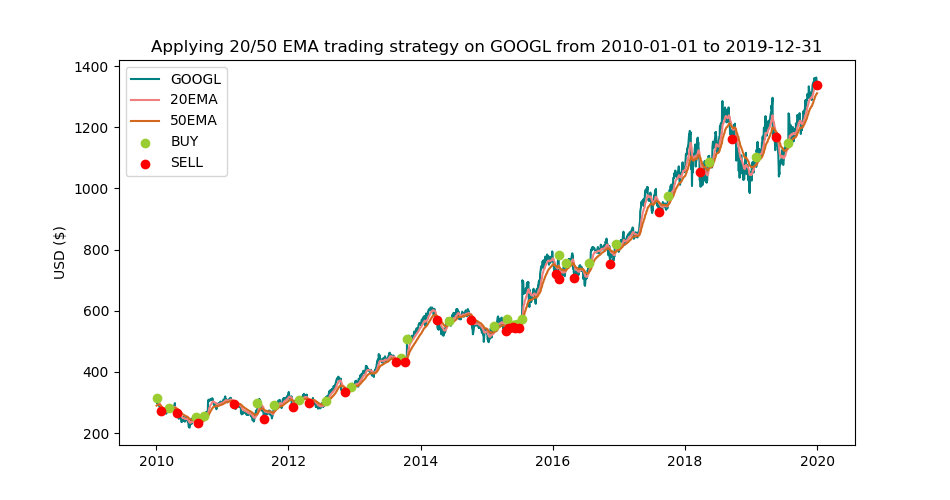

In [9]:
fig = plt.figure()
ax = plt.gca()
x_pos = period.index

ax.plot(x_pos, period['Close'], zorder = 1, c = 'teal')
ax.plot(x_pos, period['nEMA'], zorder = 1, c = 'lightcoral')
ax.plot(x_pos, period['mEMA'], zorder = 1, c= 'chocolate')

buy_sign = period[(period['Signal'] != 'N') & (period['Signal'] == 'B')]
sell_sign = period[(period['Signal'] != 'N') & (period['Signal'] == 'S')]

ax.scatter(buy_sign.index, buy_sign['Close'], color = 'yellowgreen', zorder = 2)
ax.scatter(sell_sign.index, sell_sign['Close'], color = 'red', zorder = 2)
plt.legend(['GOOGL', '20EMA', '50EMA', 'BUY', 'SELL'])
ax.set_title('Applying 20/50 EMA trading strategy on GOOGL from {} to {}'.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')))
ax.set_ylabel('USD ($)')
fig.set_size_inches(9.5, 5)

### Interactive Backtesting

Now that we have seen how the strategy worked for a given timeframe, we can integrate interactivity with the start to generate the profits and signals dynamically. For ease of change, we will redefine n, m and calculate the rolling moving average again.

In [10]:
n = 20
m = 50

if n > m:
    raise Exception("n = periods of short-term SMA, while m = periods of long-term SMA. Hence, n must be lesser than m.")
    
df['nSMA'] = df['Close'].rolling(window = n, win_type = None).mean()
df['mSMA'] = df['Close'].rolling(window = m, win_type = None).mean()

nEMA = []
mEMA = []
idx = 0
for i in range(len(df)):
    if i < n - 1:
        nEMA.append(np.nan)
        mEMA.append(np.nan)
    elif (i >= n - 1) & (i < m - 1):
        mEMA.append(np.nan)
        n_EMA = (df.loc[df.index[i], 'Close'] * multiplier_n) + (np.nan_to_num(nEMA[idx]) * (1 - multiplier_n))
        nEMA.append(n_EMA)
    elif i >= m - 1:
        n_EMA = (df.loc[df.index[i], 'Close'] * multiplier_n) + (np.nan_to_num(nEMA[idx]) * (1 - multiplier_n))
        m_EMA = (df.loc[df.index[i], 'Close'] * multiplier_m) + (np.nan_to_num(mEMA[idx]) * (1 - multiplier_m))
        nEMA.append(n_EMA)
        mEMA.append(m_EMA)
    
    if i != 0:
        idx = idx + 1

df['nEMA'] = nEMA
df['mEMA'] = mEMA

Next, we define a new function that takes an onSelect event as a parameter. Using the onSelect event, we can determine which part of the canvas (graph) were selected, and we can take the values for our calculations.

<IPython.core.display.Javascript object>


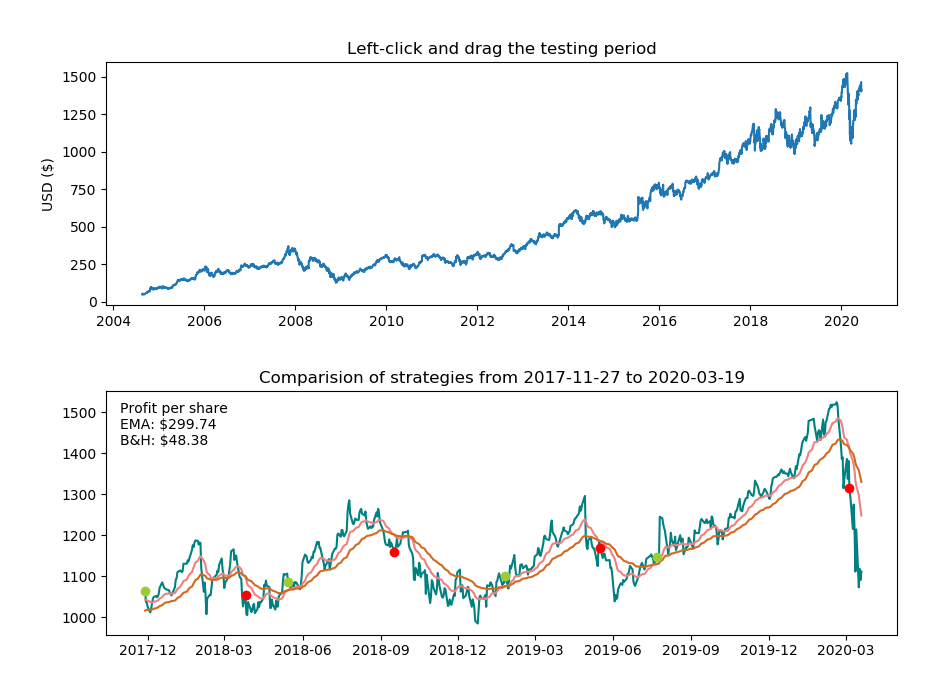

In [11]:
fig = plt.figure(figsize=(9.5, 7))
ax = fig.add_subplot(211)
ax.plot(df.index, df['Close'], '-')
ax.set_title('Left-click and drag the testing period')
ax.set_ylabel('USD ($)')

ax2 = fig.add_subplot(212)
ax2.set_title('Select a testing period above first!')
fig.tight_layout(pad = 3)

def onselect(xmin, xmax):
    start_date = pd.to_datetime(mDates.num2date(xmin, tz = None).replace(tzinfo = None))
    end_date = pd.to_datetime(mDates.num2date(xmax, tz = None).replace(tzinfo = None))
    period = extract_period(start_date, end_date)
    ax2.cla()
    ax2.set_title('Comparision of strategies from {} to {}'.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')))
    x_pos = period.index
    ax2.plot(x_pos, period['Close'], zorder = 1, c = 'teal')
    ax2.plot(x_pos, period['nEMA'], zorder = 1, c = 'lightcoral')
    ax2.plot(x_pos, period['mEMA'], zorder = 1, c= 'chocolate')
    buy_sign = period[(period['Signal'] != 'N') & (period['Signal'] == 'B')]
    sell_sign = period[(period['Signal'] != 'N') & (period['Signal'] == 'S')]

    ax2.scatter(buy_sign.index, buy_sign['Close'], color = 'yellowgreen', zorder = 2)
    ax2.scatter(sell_sign.index, sell_sign['Close'], color = 'red', zorder = 2)
    
    SMA_Profit = '${:,.2f}'.format(period['Profit'].sum())
    BnH_Profit = '${:,.2f}'.format(period['Close'].iloc[len(period) - 1] - period['Close'].iloc[0])
    diff = '${:,.2f}'.format(period['Profit'].sum() - (period['Close'].iloc[len(period) - 1] - period['Close'].iloc[0]))

    count = period[period['Signal'] != 'N'].count()['Signal']
    ax2.annotate('Profit per share\nEMA: {}\nB&H: {}'.format(SMA_Profit, BnH_Profit), xy = (120, 255), xycoords = 'figure pixels')
    ax.set_ylabel('USD ($)')
    
span = SpanSelector(ax, onselect, 'horizontal', useblit= True, rectprops=dict(alpha=0.75, facecolor='lightgrey'))